<a href="https://colab.research.google.com/github/JielingChen/Data_Science_Practice_Projects/blob/main/Copy_of_PCA_NNMF_StateOfTheUnion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the following code, the term-document matrix is created after filtering out words that occur only once as well as the most common words.

Then the term-document matrix is normalized by the length of each document.

Finally, we use PCA to summarize the documents.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package state_union to /root/nltk_data...
[nltk_data]   Unzipping corpora/state_union.zip.


Shape of the term-document matrix: (13847, 65)
Percentage of words that appear only once among all addresses: 39.17%
Words that appear only once among all addresses: reverent, misunderstood, void, on.our, vestige, remains-unconditional, breakers, peace-and, responsibility-must, unconscious, futile, hitler, ghastly, leahy, dmiral, arnold, nimitz, remain-unchanged, casts, gleam, rugged, sacrifice-in, president-we, machi, nery, devoid, fatalism, intangible-hope, abject, muster, respon, sibility, be-for, advantage-increased, ion, discern, formulating, mates, combines, herewith, reconversion.1, 1the, 398, 79th, cong., sess., peace-the, fascist, reign, retribution, all-1945, nazi-fascist, life-men, front-who, brawn, everlasting, back-the, 330,000, sailors, deservedly, possessed, advantages-vast, opportunistic, alluring, forgetting, steering, compressed, formalized, amplified, assemblies, normalcy, utilization, achieved-through, bargaining-with, attains, pursuits, productions, objective-towar

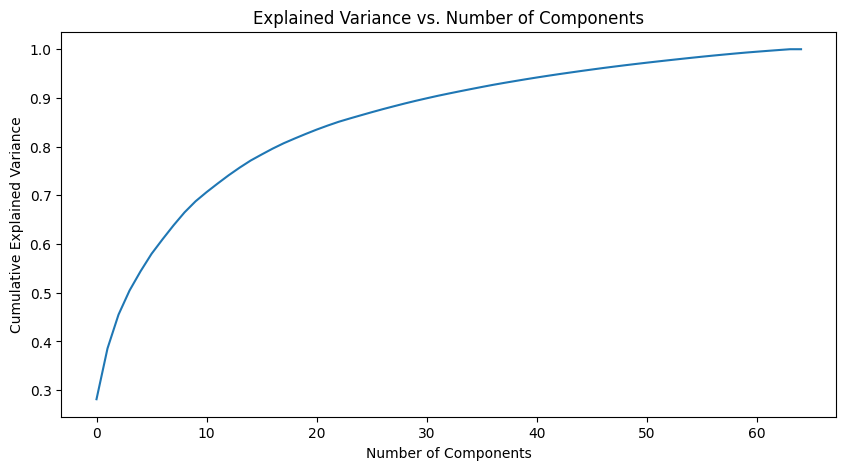

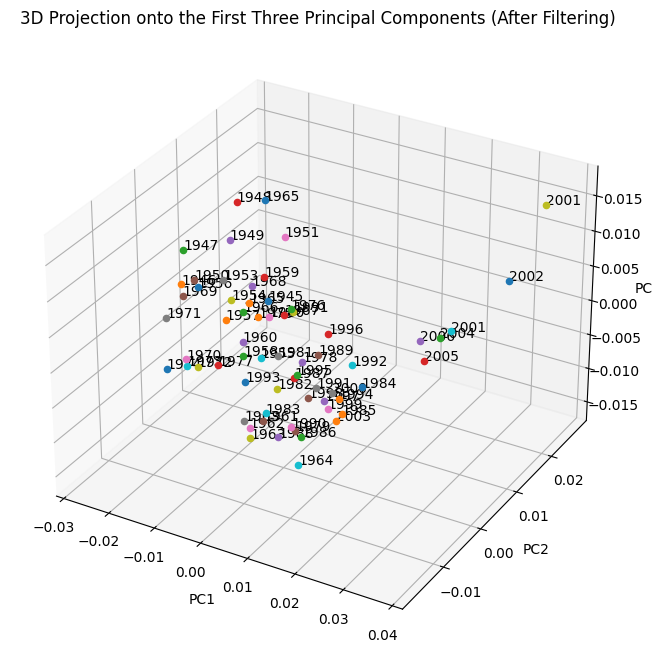

In [ ]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from nltk.corpus import state_union
from nltk import FreqDist
from collections import defaultdict, Counter
from math import log2

nltk.download('punkt')
nltk.download('state_union')

def create_term_document_matrix(addresses):
    vocab = set()
    tdm = defaultdict(lambda: [0] * len(addresses))
    global_freq = Counter()

    for i, address in enumerate(addresses):
        words = nltk.word_tokenize(address.lower())  # Lowercasing
        freq_dist = FreqDist(words)
        global_freq.update(freq_dist)

        for word, freq in freq_dist.items():
            vocab.add(word)
            tdm[word][i] = freq

    return tdm, global_freq, list(vocab)

def analyze_addresses(fileids, addresses):
    for fileid, address in zip(fileids, addresses):
        year = fileid.split('-')[0]  # Extract year from filename
        president_name = fileid.split('-')[1].split('.')[0]  # Extract president's name from filename

        words = nltk.word_tokenize(address.lower())  # Lowercasing
        freq_dist = FreqDist(words)

        # Print information
        print(f"Year: {year}")
        print(f"President: {president_name}")
        print(f"Length: {len(words)}")
        print(f"First 20 words: {' '.join(words[:20])}")
        print(f"Last 20 words: {' '.join(words[-20:])}")
        print(f"20 Most common words: {[word[0] for word in freq_dist.most_common(20)]}")
        print(f"20 Least common words: {[word[0] for word in sorted(freq_dist.items(), key=lambda x: x[1])[:20]]}")
        print("-" * 50)

if __name__ == "__main__":
    # Using actual State of the Union addresses from nltk
    fileids = state_union.fileids()
    addresses = [state_union.raw(fileid) for fileid in fileids]
    tdm, global_freq, vocab = create_term_document_matrix(addresses)
    # Compute and print the shape of the term-document matrix
    tdm_shape = (len(tdm), len(fileids))
    print(f"Shape of the term-document matrix: {tdm_shape}")

    # Compute the words that appear only once across all addresses
    single_occurrence_words = [word for word, counts in tdm.items() if sum(counts) == 1]
    percentage_single_occurrence = (len(single_occurrence_words) / len(vocab)) * 100

    # Print the percentage and the words
    print(f"Percentage of words that appear only once among all addresses: {percentage_single_occurrence:.2f}%")
    print(f"Words that appear only once among all addresses: {', '.join(single_occurrence_words)}\n")
    print("-" * 50)


    # Removing words that appear only once
    once_occurrence_words = [word for word, count in global_freq.items() if count == 0]

    # Identifying the  most common words
    top_words = [item[0] for item in global_freq.most_common(0)]

    # Removing the selected words from the vocabulary
    for word in once_occurrence_words + top_words:
        if word in tdm:
            del tdm[word]

    # Convert the term-document matrix into an array format for PCA
    data = np.array([tdm[word] for word in tdm.keys()])

    # Compute the total number of terms in each document
    doc_totals = np.sum(data, axis=0)

    # Turn frequencies into probabilities
    prob_matrix = data / doc_totals

    # Transpose the data to have documents as rows and terms as columns
    #prob_matrix_T = prob_matrix.T

    # Perform PCA
    pca = PCA()
    data_pca = pca.fit_transform(prob_matrix.T)

    # Plot explained variance vs number of components
    plt.figure(figsize=(10, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs. Number of Components')
    plt.show()

    # Plot 3D projection
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i, fileid in enumerate(fileids):
        year = fileid.split('-')[0]
        ax.scatter(data_pca[i, 0], data_pca[i, 1], data_pca[i, 2])
        ax.text(data_pca[i, 0], data_pca[i, 1], data_pca[i, 2], year, size=10, zorder=1, color='k')

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('3D Projection onto the First Three Principal Components (After Filtering)')
    plt.show()


In [ ]:
once_occurrence_words

[]

In [ ]:
top_words

[]

In [ ]:
analyze_addresses(fileids, addresses)

The following code does:

A function `top_terms_for_component` is defined that will extract the top terms (by magnitude) for a given component.

The function sorts the loadings of the specified PCA component in descending order of magnitude. It returns the terms associated with the top `n_terms` loadings.

After performing PCA (in the main execution of your code), this function is called for each of the first three components, and the top terms are printed.

This will provide a clearer interpretation of what each of the principal components represents in terms of the terms in the State of the Union addresses.

In [ ]:
def top_terms_for_component_and_power(pca, component_num, vocab, n_terms=20):
    """
    Returns the top n_terms terms for a given PCA component and
    the proportion of the total power of the component represented by these terms.
    """
    # Extract the loadings for the specified component.
    loadings = pca.components_[component_num]

    # Get the squared loadings
    squared_loadings = loadings**2

    # Get the indices of the sorted (by magnitude) squared loadings.
    sorted_idx = np.argsort(squared_loadings)[::-1]

    # Get the total power of the component (sum of squared loadings)
    total_power = np.sum(squared_loadings)

    # Get the power represented by the top n_terms
    top_power = np.sum(squared_loadings[sorted_idx[:n_terms]])

    # Return the top terms for this component and the proportion of power
    return [vocab[i] for i in sorted_idx[:n_terms]], top_power / total_power

# After performing PCA in the main part of your code...
if __name__ == "__main__":
    # ... [rest of your code above]

    # Analyze top terms and their power for the first three principal components
    for i in range(3):
        terms, power = top_terms_for_component_and_power(pca, i, vocab)
        print(f"Top terms for component {i+1}:")
        print(", ".join(terms))
        print(f"Proportion of power represented by top {len(terms)} terms: {power:.4f}")
        print("-" * 50)


Top terms for component 1:
bag, unending, reviving, enterprise, harbors, strict, pull, well-equipped, generous, bullet, amnesty, memories, maritime, unprepared, funny, untouched, valued, marble, earmark, mold
Proportion of power represented by top 20 terms: 0.8944
--------------------------------------------------
Top terms for component 2:
reviving, generous, well-equipped, unending, pull, memories, marble, choicesąxchoices, group, strict, thrifty, tired, enterprise, mothball, wreaks, bullet, yeltsin, lyndon, earmark, tuesday
Proportion of power represented by top 20 terms: 0.8339
--------------------------------------------------
Top terms for component 3:
enterprise, reviving, memories, group, marble, strict, example-we, unending, independent, bag, harbors, tutoring, choicesąxchoices, blindfolded, tired, commander, assembled, mislead, deem, exclusively
Proportion of power represented by top 20 terms: 0.8931
--------------------------------------------------


Using TF-IDF can provide a more informative representation of the documents, especially when you're dealing with a large collection. It helps diminish the weight of terms that occur very frequently in the dataset and increases the weight of terms that occur rarely.

Here's how you can implement a TF-IDF transformation:

Compute term frequency (TF) which is the number of times a term appears in a document.
Compute inverse document frequency (IDF) which diminishes the weight of terms that occur very frequently in the document set and increases the weight of terms that occur rarely.
Multiply the TF by IDF for each term in each document.
Let's implement this:

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package state_union to /root/nltk_data...
[nltk_data]   Package state_union is already up-to-date!


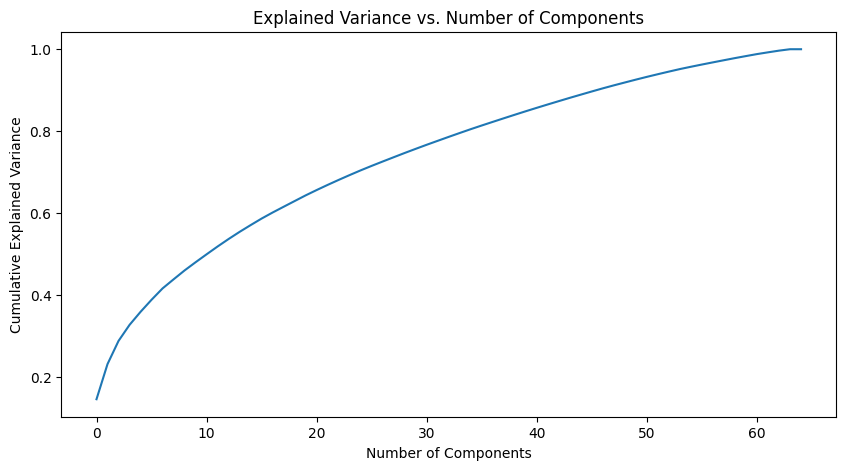

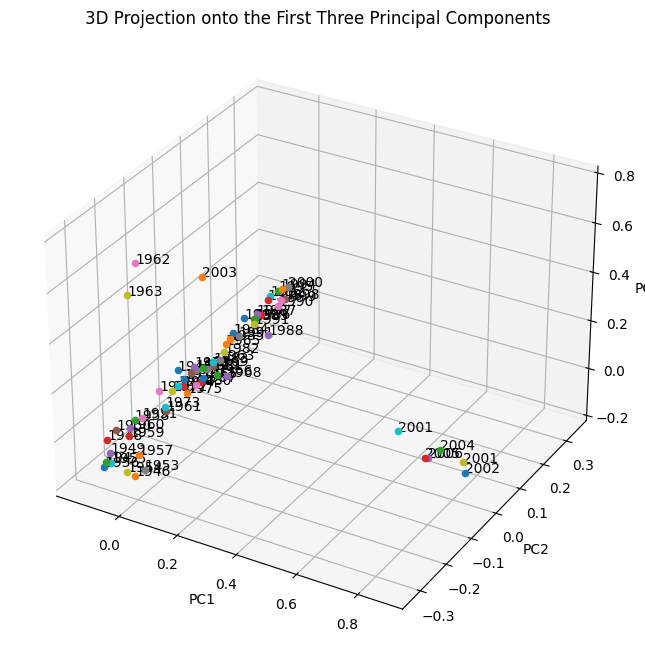

In [ ]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from nltk.corpus import state_union
from nltk import FreqDist
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfTransformer

nltk.download('punkt')
nltk.download('state_union')


def create_term_document_matrix(addresses):
    vocab = set()
    tdm = defaultdict(lambda: [0] * len(addresses))
    global_freq = Counter()

    for i, address in enumerate(addresses):
        words = nltk.word_tokenize(address.lower())  # Lowercasing
        freq_dist = FreqDist(words)
        global_freq.update(freq_dist)

        for word, freq in freq_dist.items():
            vocab.add(word)
            tdm[word][i] = freq

    return tdm, global_freq, list(vocab)


def transform_to_tfidf(tdm, vocab):
    tdm_array = np.array([tdm[word] for word in vocab])
    tdm_array_T = tdm_array.T

    transformer = TfidfTransformer()
    tfidf_matrix = transformer.fit_transform(tdm_array_T)

    return tfidf_matrix.toarray()


if __name__ == "__main__":
    # Using actual State of the Union addresses from nltk
    fileids = state_union.fileids()
    addresses = [state_union.raw(fileid) for fileid in fileids]

    tdm, global_freq, vocab = create_term_document_matrix(addresses)

    # Removing words that appear only once
    once_occurrence_words = set(word for word, count in global_freq.items() if count == 1)

    # Identifying the  most common words
    top_words = set(item[0] for item in global_freq.most_common(10))

    # Filtering out the selected words from the vocabulary
    vocab = [word for word in vocab if word not in once_occurrence_words and word not in top_words]
    tdm = {word: tdm[word] for word in vocab}

    tfidf_matrix = transform_to_tfidf(tdm, vocab)

    # Perform PCA on the tfidf_matrix
    pca = PCA()
    data_pca = pca.fit_transform(tfidf_matrix)

    # Plot explained variance vs number of components
    plt.figure(figsize=(10, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs. Number of Components')
    plt.show()

    # Plot 3D projection
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i, fileid in enumerate(fileids):
        year = fileid.split('-')[0]
        ax.scatter(data_pca[i, 0], data_pca[i, 1], data_pca[i, 2])
        ax.text(data_pca[i, 0], data_pca[i, 1], data_pca[i, 2], year, size=10, zorder=1, color='k')

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('3D Projection onto the First Three Principal Components')
    plt.show()


In [ ]:
def top_terms_for_component_and_power(pca, component_num, vocab, n_terms=20):
    """
    Returns the top n_terms terms for a given PCA component and
    the proportion of the total power of the component represented by these terms.
    """
    # Extract the loadings for the specified component.
    loadings = pca.components_[component_num]

    # Get the squared loadings
    squared_loadings = loadings**2

    # Get the indices of the sorted (by magnitude) squared loadings.
    sorted_idx = np.argsort(squared_loadings)[::-1]

    # Get the total power of the component (sum of squared loadings)
    total_power = np.sum(squared_loadings)

    # Get the power represented by the top n_terms
    top_power = np.sum(squared_loadings[sorted_idx[:n_terms]])

    # Fetch the top terms for this component and append a sign based on the loading coefficient
    top_terms = []
    for idx in sorted_idx[:n_terms]:
        term = vocab[idx]
        sign = "+" if loadings[idx] > 0 else "-"
        top_terms.append(f"{term} ({sign})")

    # Return the top terms with their sign for this component and the proportion of power
    return top_terms, top_power / total_power

# After performing PCA in the main part of your code...
if __name__ == "__main__":


    # Analyze top terms and their power for the first three principal components
    for i in range(3):
        terms, power = top_terms_for_component_and_power(pca, i, vocab)
        print(f"Top terms for component {i+1}:")
        print(", ".join(terms))
        print(f"Proportion of power represented by top {len(terms)} terms: {power:.4f}")
        print("-" * 50)


Top terms for component 1:
( (+), ) (+), applause (+), that (-), for (-), i (-), this (-), be (-), it (-), as (-), which (-), terrorists (+), but (-), can (-), have (-), terror (+), iraq (+), is (-), all (-), afghanistan (+)
Proportion of power represented by top 20 terms: 0.8643
--------------------------------------------------
Top terms for component 2:
you (+), i (+), 's (+), - (-), which (-), that (+), be (-), america (+), -- (+), n't (+), tonight (+), is (-), 're (+), do (+), 've (+), shall (-), it (+), let (+), who (+), nations (-)
Proportion of power represented by top 20 terms: 0.4309
--------------------------------------------------
Top terms for component 3:
- (+), -- (-), that (-), ... (+), ) (-), ( (-), be (-), will (-), i (-), government (-), this (-), as (-), not (+), have (-), saddam (+), applause (-), hussein (+), congress (-), are (-), which (-)
Proportion of power represented by top 20 terms: 0.7791
--------------------------------------------------


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package state_union to /root/nltk_data...
[nltk_data]   Package state_union is already up-to-date!


Shape of the term-document matrix: (7284, 65)


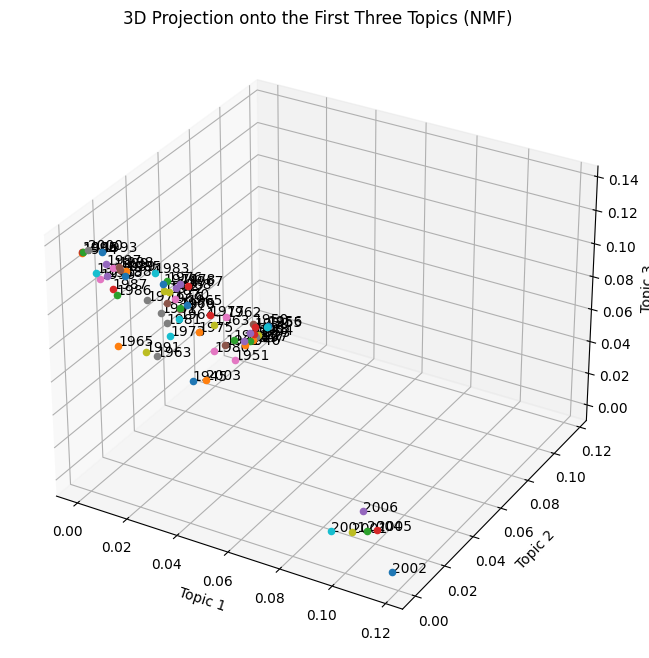

In [ ]:
from sklearn.decomposition import NMF
import nltk
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from nltk.corpus import state_union
from nltk import FreqDist
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfTransformer

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')


nltk.download('punkt')
nltk.download('state_union')

def create_term_document_matrix(addresses):
    # Enhanced Preprocessing
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    vocab = set()
    tdm = defaultdict(lambda: [0] * len(addresses))
    global_freq = Counter()

    for i, address in enumerate(addresses):
        words = nltk.word_tokenize(address.lower())  # Lowercasing

        # Remove stopwords and perform stemming
        words = [stemmer.stem(word) for word in words if word not in stop_words and word.isalpha()]

        freq_dist = FreqDist(words)
        global_freq.update(freq_dist)

        for word, freq in freq_dist.items():
            vocab.add(word)
            tdm[word][i] = freq

    return tdm, global_freq, list(vocab)

def transform_to_tfidf(tdm, vocab):
    tdm_array = np.array([tdm[word] for word in vocab])
    tdm_array_T = tdm_array.T

    transformer = TfidfTransformer()
    tfidf_matrix = transformer.fit_transform(tdm_array_T)

    return tfidf_matrix.toarray()


if __name__ == "__main__":
    # Using actual State of the Union addresses from nltk
    fileids = state_union.fileids()
    addresses = [state_union.raw(fileid) for fileid in fileids]

    tdm, global_freq, vocab = create_term_document_matrix(addresses)

    # Removing words that appear only once
    once_occurrence_words = set(word for word, count in global_freq.items() if count == 0)

    # Identifying the  most common words
    top_words = set(item[0] for item in global_freq.most_common(0))

    # Filtering out the selected words from the vocabulary
    vocab = [word for word in vocab if word not in once_occurrence_words and word not in top_words]
    tdm = {word: tdm[word] for word in vocab}

    # Compute and print the shape of the term-document matrix
    tdm_shape = (len(tdm), len(fileids))
    print(f"Shape of the term-document matrix: {tdm_shape}")

    tfidf_matrix = transform_to_tfidf(tdm, vocab)

    # Perform NMF on the tfidf_matrix
    num_topics = 3
    nmf = NMF(n_components=num_topics, init='random')
    nmf_output = nmf.fit_transform(tfidf_matrix)

    # Plot 3D projection
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i, fileid in enumerate(fileids):
        year = fileid.split('-')[0]
        ax.scatter(nmf_output[i, 0], nmf_output[i, 1], nmf_output[i, 2])
        ax.text(nmf_output[i, 0], nmf_output[i, 1], nmf_output[i, 2], year, size=10, zorder=1, color='k')

    ax.set_xlabel('Topic 1')
    ax.set_ylabel('Topic 2')
    ax.set_zlabel('Topic 3')
    ax.set_title('3D Projection onto the First Three Topics (NMF)')
    plt.show()


In [ ]:
def top_terms_for_component_and_weight(nmf, nmf_output, component_num, vocab, n_terms=20):
    """
    Returns the top n_terms terms for a given NMF component and
    the proportion of the component's weight across all documents relative to the total weights of all components.
    """
    # Extract the loadings for the specified component.
    loadings = nmf.components_[component_num]

    # Get the indices of the sorted loadings.
    sorted_idx = np.argsort(loadings)[::-1]

    # Fetch the top terms for this component
    top_terms = [vocab[idx] for idx in sorted_idx[:n_terms]]

    # Calculate the weight of the component across all documents
    component_weight = np.sum(nmf_output[:, component_num])

    # Calculate the total weight across all documents and all components
    total_weight = np.sum(nmf_output)

    # Calculate the proportion of the component's weight relative to the total weight
    proportion = component_weight / total_weight if total_weight != 0 else 0

    return top_terms, proportion

# After performing NMF in the main part of your code...
if __name__ == "__main__":
    # ... [rest of your code above]

    # Analyze top terms and their proportions for the first three NMF topics
    for i in range(3):
        terms, proportion = top_terms_for_component_and_weight(nmf, nmf_output, i, vocab)
        print(f"Top terms for component {i+1}:")
        print(", ".join(terms))
        print(f"Proportion of the component's weight across all documents: {proportion:.4f}")
        print("-" * 50)


Top terms for component 1:
applaus, terrorist, america, terror, american, iraq, nation, must, world, secur, iraqi, afghanistan, countri, freedom, regim, peopl, tonight, make, everi, act
Proportion of the component's weight across all documents: 0.1040
--------------------------------------------------
Top terms for component 2:
nation, must, year, world, program, govern, congress, state, peopl, shall, peac, econom, new, increas, feder, need, recommend, continu, unit, free
Proportion of the component's weight across all documents: 0.4095
--------------------------------------------------
Top terms for component 3:
year, american, america, peopl, must, us, work, new, tonight, let, nation, make, world, congress, help, time, everi, one, famili, govern
Proportion of the component's weight across all documents: 0.4865
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

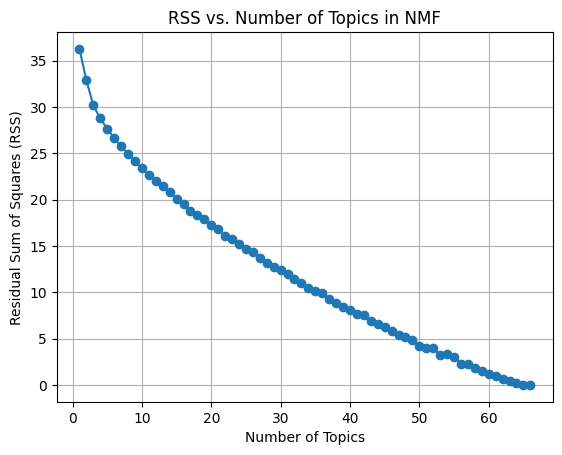

In [ ]:
def compute_nmf_rss(matrix, n_components, init='random', random_state=0):
    nmf = NMF(n_components=n_components, init=init, random_state=random_state)
    W = nmf.fit_transform(matrix)
    H = nmf.components_
    approx = np.dot(W, H)
    rss = np.sum((matrix - approx) ** 2)
    return rss

# Compute RSS for a range of topic numbers
topic_range = range(1, 67)  #
rss_values = [compute_nmf_rss(tfidf_matrix, n) for n in topic_range]

# Plotting
plt.plot(topic_range, rss_values, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Residual Sum of Squares (RSS)')
plt.title('RSS vs. Number of Topics in NMF')
plt.grid(True)
plt.show()
